# General Assembly Capstone: Time Series Forecasting of Texas Electricity Data
----

## <span style="color:Green">03 - Univariate Time Series Model of Wind Generation</span>      
----

#### The below notebook conducts univariate time series analysis on the ERCOT wind data from 2011-2020. The original dataset is resampled at the weekly level and utilizes a SARIMA model to make predicting 2 years into the future. Guidance on developing the model came from my General Assembly Data Science Immersive coursework, as well as the below source:

https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python#Econometric-approach

#### Raw data source:

http://www.ercot.com/gridinfo/generation

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

%matplotlib inline
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from itertools import product                # some useful functions
from tqdm import tqdm_notebook

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.simplefilter(action="ignore")

# 1. Load and arrange our data

In [2]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')

In [3]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [4]:
df.dtypes

date        object
Biomass    float64
Coal       float64
Hydro      float64
Nuclear    float64
Other      float64
Solar      float64
Wind       float64
NGas       float64
dtype: object

#### The below function utilizes our main dataframe with the energy source of our choosing. Additionally, the date column is converted to datetime and set as the index. Because we need to model on weekly data, we resample the data as weekly and drop all NANs. Finally, we convert the output to a dataframe.

In [4]:
def df_converter(data, source):
    data = data[['date', source]]
    data['date']=pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data['Weekly'] = data.resample('W').mean()
    data = data['Weekly'].dropna()
    data = pd.DataFrame(data)
    return data


In [5]:
df_weekly = df_converter(df, 'Wind')

In [ ]:
df_weekly.head()

# 2. Moving average & anomaly detection

#### Prior to modeling, let's take a closer look at the trends and possible anomalies present within each energy source's data.

In [8]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_weekly, 7)

250728.71633295921

#### Our goal in time series modeling is to forecast the future, which is inherently based on the past. The above function gives us an idea of what our next value will be based on a rolling average of the last four weeks.

In [9]:

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [29]:
df_weekly_anomaly = df_weekly.copy()
df_weekly_anomaly.iloc[-20] = df_weekly_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

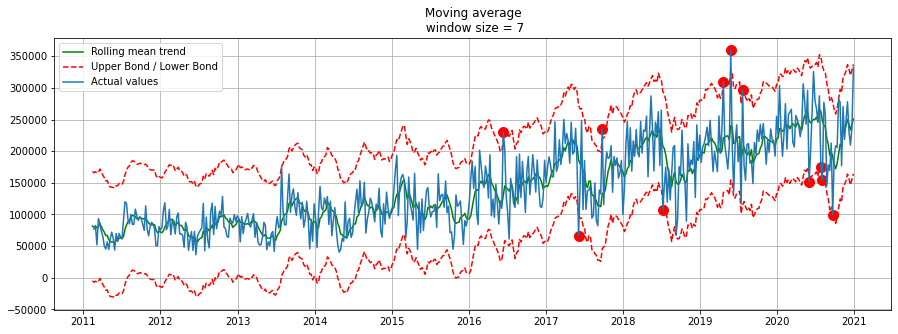

In [31]:
plotMovingAverage(df_weekly, 7, plot_intervals=True, plot_anomalies=True)

#### Above, we can see how the data is captured by a 4-week moving average, as well as with upper and lower bounds based on adding and differencing,respectively, the mean absolute error from the rolling average for each data point. Additionally, anomaly detection indicates points in the the data that exist outside of our upper and lower bounds. The anomalies present in the wind generation data occur mostly after 2017. It's worth noting that this is near the point in time where wind and coal reach parity in terms of their contribution to the grid. Therefore, these anomalies are likely indicating of wind becoming more prominent in the Texas electricity mix. As it becomes more utilized, it tends to show large swings due the nature sometimes causing huge influxes of wind energy or a lack thereof.

# 3. Identifying stationarity

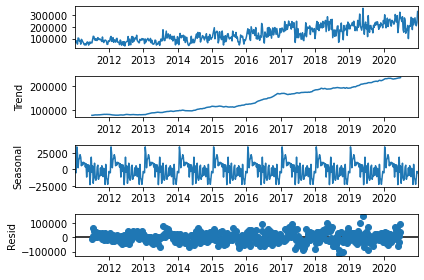

In [56]:
decomp = seasonal_decompose(df_weekly)


decomp.plot();

#### The above decompositon of wind electricity generation relays both trend and seasonality in the weekly data. Let's apply the Augmented Dickey-Fuller Test and plot autocorrealtion and partial autocorrelations to better understand stationarity in the data."

In [14]:
def tsplot(df_weekly, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        df_weekly.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(df_weekly)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(df_weekly, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(df_weekly, lags=lags, ax=pacf_ax)
        plt.tight_layout()

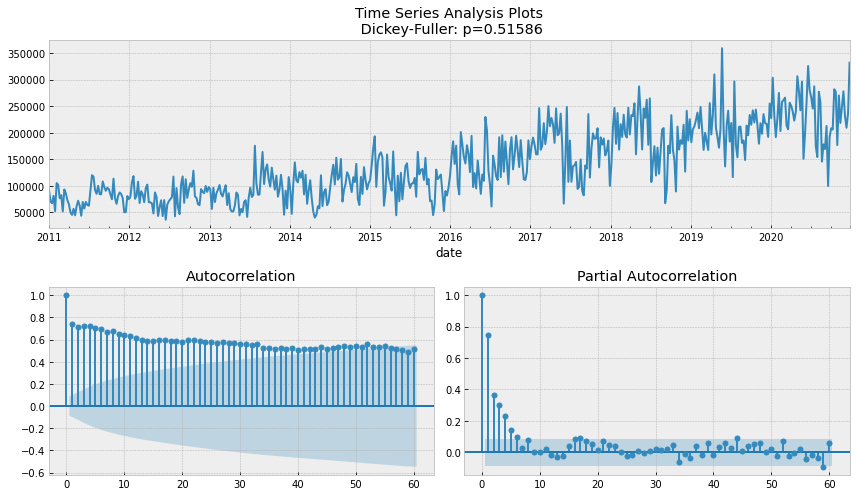

In [18]:
tsplot(df_weekly.Weekly, lags = 60)

#### Above, we can see trend and slight seasonality in our data. The p-value of 0.52 indicates the data is most certainly not stationarity. Additionally, we see that the autocorrelation function having a signicant number of lags. Below, we take the difference of our data, and we can see that there is no longer trend or seasonality in the data. Additionally, we have reduced the number of significant lags in our autocorrelation plot.

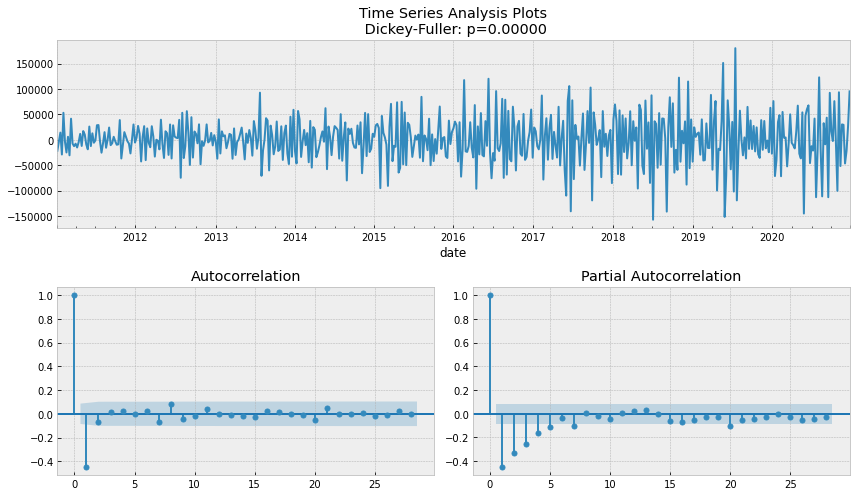

In [28]:
df_diff = df_weekly.Weekly.diff().dropna()
tsplot(df_diff)

# 4. Optimizing and fitting a SARIMA model

In [19]:
# setting initial values and some bounds for them
ps = range(2, 4)
d=1 
qs = range(2, 4)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 52 # season length is 7 due to yearly seasonality with daily data

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

#### Below, we will optimize our autoregressor, moving average, seasonal autoregessor, and seasonal moving average terms such that the Akaike Information Criterion (AIC) is minimized. This AIC value gives a relative score based on each of the combination of parameters listed above. AIC acts to find the model that best balances fit with generalizability.

In [20]:

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_weekly.Weekly, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [21]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 10min 54s, sys: 15.3 s, total: 11min 9s
Wall time: 9min 3s


In [22]:
result_table

,parameters,aic
0,"(2, 2, 0, 1)",11322.942480
1,"(2, 3, 0, 1)",11323.071096
2,"(3, 2, 0, 1)",11324.355332
3,"(2, 2, 1, 1)",11324.458604
4,"(3, 3, 0, 1)",11324.504335
5,"(2, 3, 1, 1)",11324.587760
6,"(3, 2, 1, 1)",11325.964452
7,"(3, 3, 1, 1)",11326.089976
8,"(2, 3, 1, 0)",11366.635888
9,"(2, 2, 1, 0)",11368.050509


#### Above, we can see the best parameters for our model, wich are stored as a table and the parameters with the lowest AIC will be refenced below when we instantiate our SARIMA model. Additionally, our model utilizes one round of differencing to account for seasonality in our data.

In [23]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_weekly.Weekly, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               Weekly   No. Observations:                  522
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -5655.471
Date:                              Sun, 18 Apr 2021   AIC                          11322.942
Time:                                      15:48:34   BIC                          11347.846
Sample:                                  01-02-2011   HQIC                         11332.741
                                       - 12-27-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1104      1.329      0.083      0.934      -2.495       2.715
ar.L2         -0.05

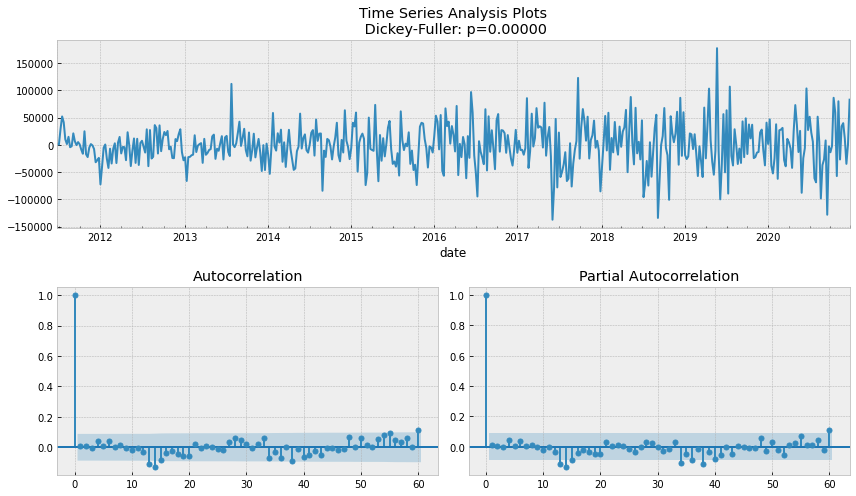

In [24]:
tsplot(best_model.resid[24+1:], lags=60)

#### Above, we can see our residual plot shows a decent spread from the zero in latter years of the dataset. This increased inability to model the data could be attributed to its increased use in the energy mix. As it becomes more prevalent, it's intermittency leads to increased challenges in predicting it's use as a generation source into the future.

# 5. Plot our SARIMA

#### Let's define mean absolute percentage error as a function that we will use for plotting our SARIMA model below

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.suptitle("ERCOT Electricity Generation from Wind", fontsize= 24)
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error), fontsize= 20)
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16)
    plt.grid(True);

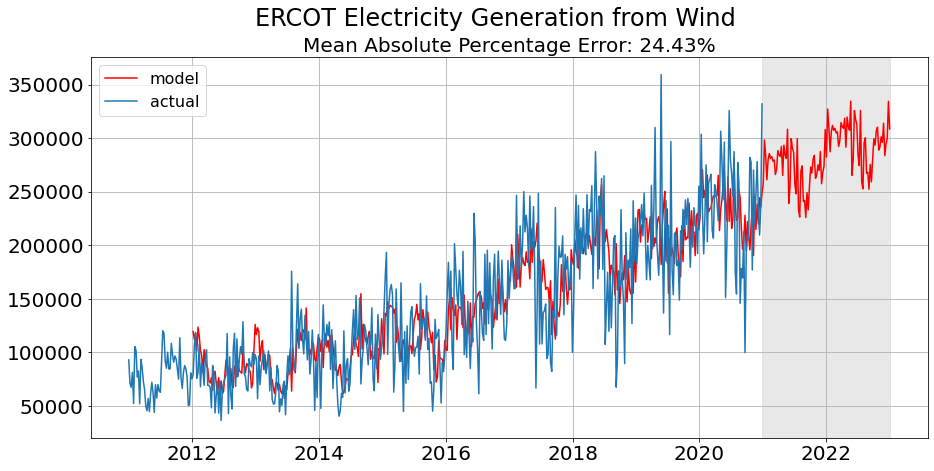

In [44]:
plotSARIMA(df_weekly, best_model, 104)


#### The final output of the above modeling depicts a forecast two years into the future. While this is unlikely to be the true values going forward, the SARIMA model provides a potential scenario of how electricity generation using wind energy will vary in the future. With the parameter optimzation for the SARIMA inputs, the model yielded a mean absolute percentage error of 24%. In general, it captured the seasonality present in the data, as well as the likely continued increasing trend in wind energy use. As noted in the anomaly detection above, we can see the model does not capture the variability present in the actual data.